In [18]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import os
import sys 
import configparser
import pandas as pd 
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from matplotlib import cycler
from os.path import join as oj
from torch.utils.data import TensorDataset, DataLoader
import pickle as pkl
from sklearn.preprocessing import StandardScaler,MinMaxScaler
sys.path.insert(0, "../src")
import severson_data
import models
import snl_data
import seaborn as sns
import pickle as pkl
pd.set_option('display.float_format', lambda x: '%.2f' % x)
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

In [20]:
colours = ['#208F90', '#8F2317','#17608F','#8F5F17','#f2f3f4','#E56399','#DE6E4B']


sns.set_palette(sns.color_palette(colours))


colors = cycler('color',
                colours)
plt.rc('axes', facecolor='#FFFFFF', edgecolor='#000000',
       axisbelow=True, grid=True, prop_cycle=colors)

In [21]:
config = configparser.ConfigParser()
config.read('../config.ini');
result_path =config['PATHS']['result_path'] 

In [22]:
model_path  = '../models/snl_models'
fig_path =config['PATHS']['figure_path'] 
fnames = sorted([oj(model_path, fname) for fname in os.listdir(model_path) if "pkl" in fname]) 
results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in (fnames)] 


In [23]:
results_all = pd.concat(results_list, axis=1).T.infer_objects()

results_all.experiment_name.unique()


array(['SNLSeed0', 'SNL', 'SNLSanitycheck3'], dtype=object)

In [24]:
my_sue = 'SNL'
results = results_all[results_all.experiment_name == my_sue]
results = results.reset_index()

my_results = None


my_results = results[[ 'best_val_loss', 'dropout', 'hidden_size','hidden_size_lstm',
      ]].groupby([ 'hidden_size','hidden_size_lstm', ]).mean()




my_results

,,best_val_loss,dropout
hidden_size,hidden_size_lstm,,
32,32,1.44,0.00


In [25]:
results =results[results.dropout  == .0]
results = results.sort_values('seed')
results = results.reset_index()


In [26]:
best_model_idx = results.best_val_loss.argmin()
seq_length = 100
start_cycle = 10



hidden_size = results.hidden_size[best_model_idx]

# load data

In [27]:

x, y, c, var, key_list = snl_data.load_data(include_key_list = True)
x_scaled  = snl_data.scale_x(x, )

x_preprocessed = snl_data.remove_outliers(x, y)
old_x = x_preprocessed.copy()
smoothed_x = severson_data.smooth_x(x_preprocessed,y, num_points=20)

C:\Users\lauri\AppData\Roaming\Python\Python39\site-packages\scipy\interpolate\interpolate.py:605: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\lauri\AppData\Roaming\Python\Python39\site-packages\scipy\interpolate\interpolate.py:608: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


In [28]:
train_idxs , val_idxs,test_idxs= severson_data.get_split(len(x), seed =42)

qc_variance_scaler = StandardScaler().fit(var[train_idxs]) 
var = qc_variance_scaler.transform(var)

augmented_data =np.hstack([c, var]) 


In [29]:
train_x, train_y, train_s = severson_data.assemble_dataset(
    smoothed_x[train_idxs],y[train_idxs]-10,
    augmented_data[train_idxs],
    seq_len=100,
)

In [30]:

min_val = .85
max_val = 1

capacity_output_scaler = MinMaxScaler((-1, 1), clip=True).fit(
    np.maximum(np.minimum(train_y[:, 0:1], max_val), min_val)
)

# Load Models

In [31]:

input_dim = train_x.shape[2]   # Number of input features (e.g. discharge capacity)
num_augment = train_s.shape[1]  # three  values of charging schedule (avg and last) plus the variance



my_models = [models.Uncertain_LSTM(1 , 
                            train_s.shape[1] , 
                            num_hidden =  results.iloc[i].hidden_size, 
                              
                            num_hidden_lstm =  results.iloc[i].hidden_size_lstm, 
                            seq_len= 100, 
                            n_layers =2, 
                            dropout =.0).to(device) for i, _ in enumerate(results.file_name)] 
for i, file_name in enumerate(results.file_name):
    my_models[i].load_state_dict(torch.load(oj(model_path,file_name+".pt")))
    my_models[i] = my_models[i].to(device)

# Run models on test set

In [44]:
cycle_dict = {}

In [45]:
num_samples = 10
my_quantile = .1
max_steps = 900

seq_length = 400
used_idxs =  test_idxs#train_idxs[10:20]#for actually new data, use test_idxs

In [46]:
for seq_length in [100,200,400]:
    test_seq_list = []
    test_seq_upper_quantile_list = []
    test_seq_lower_quantile_list = []
    test_life_pred_list = []
    test_seq_std_list = []

    all_outputs_arr = np.empty( (len(used_idxs),max_steps,len(my_models), num_samples,))
    # used_idxs =  np.arange(len(x))#for actually new data, use test_idxs
    for i,model in tqdm(enumerate(my_models)):

        supp_val_data =  np.hstack([augmented_data[used_idxs],np.ones((len(used_idxs),1))*np.log(seq_length) ])

        test_seq = old_x[used_idxs][:, :seq_length,None  ].copy()
        extended_seq = np.swapaxes(np.reshape(np.repeat(np.swapaxes(test_seq, 0,-1)[:,:,:,None],num_samples, axis =-1), (1, seq_length, -1)),0,-1)

        extended_supp_data = np.swapaxes(np.reshape(np.repeat(np.swapaxes(supp_val_data, 0,-1)[:,:,None],num_samples, axis =-1), (supp_val_data.shape[1], -1)),0,-1)

        with torch.no_grad():
            while((np.all(extended_seq[:,-1] < 1e-3) == False ) *(extended_seq.shape[1] < max_steps)):


                supp_val_data_torch = torch.from_numpy(extended_supp_data).to(device).float()

                test_seq_torch = torch.from_numpy(extended_seq[:, - seq_length:]).to(device).float()

                model.reset_hidden_state()        
                (state_mean_mean, state_var) = model(test_seq_torch, supp_val_data_torch)
                if num_samples >1:
                    state_mean_noisy   = state_mean_mean  +  torch.normal(0, (torch.sqrt(state_var)))   
                else:
                    state_mean_noisy   = state_mean_mean 

                state_mean_transformed = torch.from_numpy(capacity_output_scaler.inverse_transform(state_mean_noisy.cpu().numpy())).to(device)

                state_mean_transformed[:,0] = state_mean_transformed[:,0]*(test_seq_torch[:, -1, 0 ])

                extended_supp_data[:,-1] = np.log(np.exp(extended_supp_data[:,-1])+1)
                extended_seq = np.hstack([extended_seq, state_mean_transformed.cpu().numpy()[:, None]])
        used_steps = extended_seq.shape[1]
        reshaped = np.swapaxes(np.reshape(np.swapaxes(extended_seq,0,1),(1,used_steps, -1, num_samples)),0,-2)
        all_outputs_arr[:,:,i,:] = reshaped[:,:,0]

    all_outputs_arr = np.reshape(np.transpose(all_outputs_arr, (0,2,3, 1)), (len(used_idxs), -1, max_steps))

    cycle_dict[seq_length] = np.copy(all_outputs_arr)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [48]:
cycle_dict[100]

(10, 50, 900)

In [ ]:
my_index =0
fig, axes = plt.subplots(ncols=1, nrows =1, figsize = (20, 8))
linewidth = 4

for i, ax in enumerate(fig.get_axes()):
    if i >= len(used_idxs):
        break
    
    ax.plot(x_preprocessed[used_idxs[i]], c = colours[1], label = 'Data',linewidth = linewidth)
#     ax.set_xlabel(key_list[used_idxs[i]])

        
    lower_limit = np.quantile(all_outputs_arr[i], my_quantile/2, axis = 0)
    upper_limit = np.quantile(all_outputs_arr[i], 1-my_quantile/2, axis = 0)
    ax.fill_between(np.arange(max_steps), upper_limit, lower_limit , facecolor=colours[0], alpha=0.2)
    ax.plot(plt.np.quantile(all_outputs_arr[i], .5, axis = 0), c= colours[0], label = 'Predicted',linewidth = linewidth)

    
    ax.set_ylim(0.5,1)


    ax.set_xlim(0,y[used_idxs[i]]-10)
#     ax.set_xlim(90,110)
    ax.axvline(x = seq_length , linestyle = "--", c = 'k', label = 'Used for prediction')
axes[-2,-1].legend(loc =1)
plt.tight_layout()

plt.savefig(oj(fig_path,"SNL_predictions_ensemble_{seqlen}.pdf".format(seqlen=seq_length, )) )

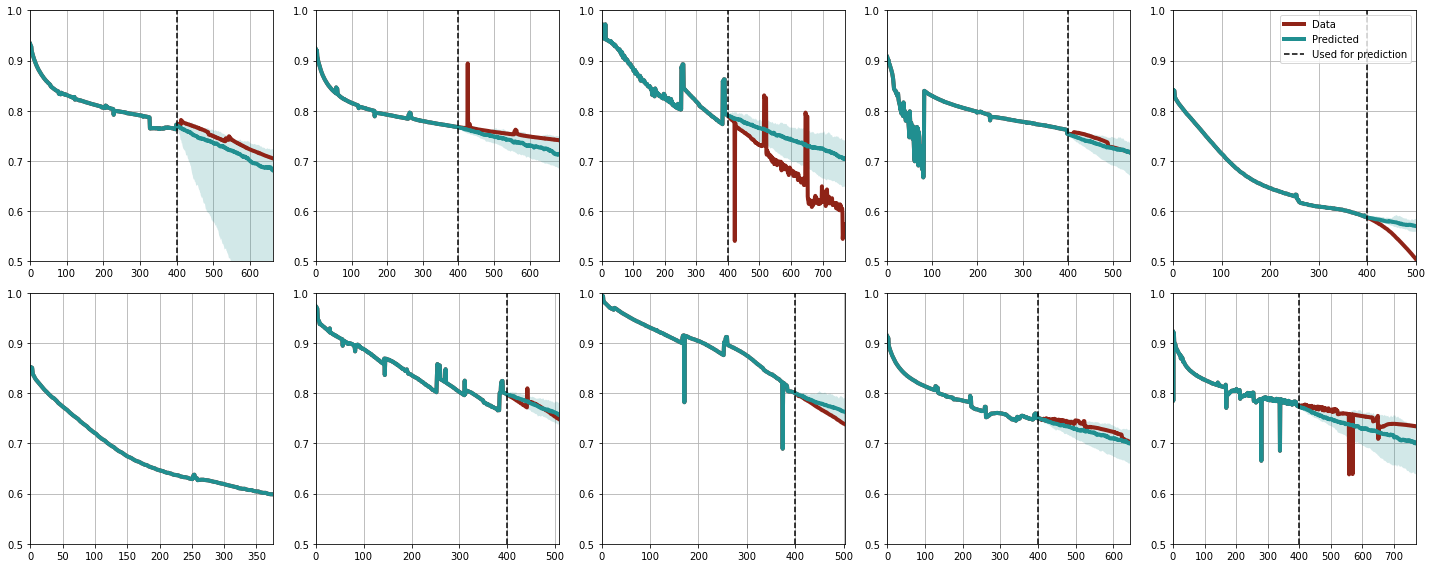

In [42]:

fig, axes = plt.subplots(ncols=5, nrows =2, figsize = (20, 8))
linewidth = 4

for i, ax in enumerate(fig.get_axes()):
    if i >= len(used_idxs):
        break
    
    ax.plot(x_preprocessed[used_idxs[i]], c = colours[1], label = 'Data',linewidth = linewidth)
#     ax.set_xlabel(key_list[used_idxs[i]])

        
    lower_limit = np.quantile(all_outputs_arr[i], my_quantile/2, axis = 0)
    upper_limit = np.quantile(all_outputs_arr[i], 1-my_quantile/2, axis = 0)
    ax.fill_between(np.arange(max_steps), upper_limit, lower_limit , facecolor=colours[0], alpha=0.2)
    ax.plot(np.quantile(all_outputs_arr[i], .5, axis = 0), c= colours[0], label = 'Predicted',linewidth = linewidth)

    
    ax.set_ylim(0.5,1)


    ax.set_xlim(0,y[used_idxs[i]]-10)
#     ax.set_xlim(90,110)
    ax.axvline(x = seq_length , linestyle = "--", c = 'k', label = 'Used for prediction')
axes[-2,-1].legend(loc =1)
plt.tight_layout()

plt.savefig(oj(fig_path,"SNL_predictions_ensemble_{seqlen}.pdf".format(seqlen=seq_length, )) )

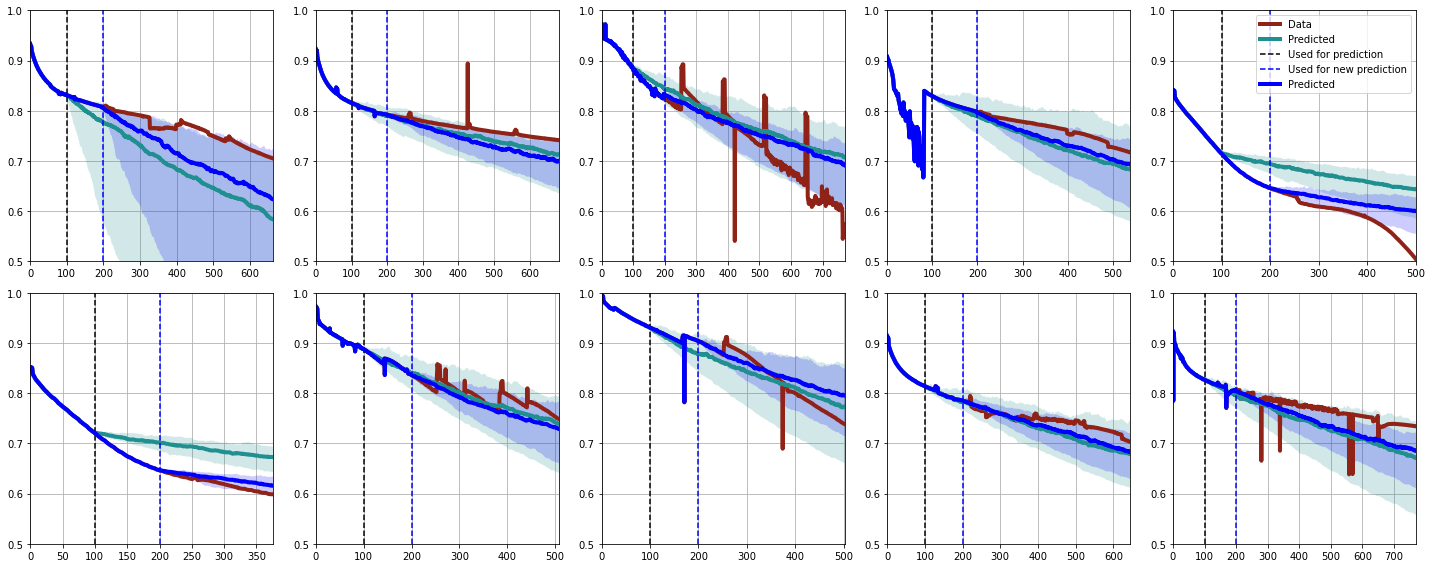

In [164]:

fig, axes = plt.subplots(ncols=5, nrows =2, figsize = (20, 8))
linewidth = 4

for i, ax in enumerate(fig.get_axes()):
    if i >= len(used_idxs):
        break
    
    ax.plot(x_preprocessed[used_idxs[i]], c = colours[1], label = 'Data',linewidth = linewidth)
#     ax.set_xlabel(key_list[used_idxs[i]])

        
    ax.fill_between(np.arange(max_steps), 
                    np.quantile(all_outputs_arr_100[i], 1-my_quantile/2, axis = 0), 
                    np.quantile(all_outputs_arr_100[i], my_quantile/2, axis = 0) , facecolor=colours[0], alpha=0.2)
    ax.plot(plt.np.quantile(all_outputs_arr_100[i], .5, axis = 0), c= colours[0], label = 'Predicted',linewidth = linewidth)
    ax.axvline(x = 100 , linestyle = "--", c = 'k', label = 'Used for prediction')
    ax.set_ylim(0.5,1)
    ax.axvline(x = seq_length , linestyle = "--", c = 'b', label = 'Used for new prediction')

    ax.set_xlim(0,y[used_idxs[i]]-10)
    
    
    ax.fill_between(np.arange(max_steps), 
                    np.quantile(all_outputs_arr[i], 1-my_quantile/2, axis = 0), 
                    np.quantile(all_outputs_arr[i], my_quantile/2, axis = 0) , facecolor='b', alpha=0.2)
    ax.plot(plt.np.quantile(all_outputs_arr[i], .5, axis = 0), c= 'b', label = 'Predicted',linewidth = linewidth)
    

axes[-2,-1].legend(loc =1)
plt.tight_layout()

plt.savefig(oj(fig_path,"SNL_predictions_ensemble_uncert.pdf".format(seqlen=seq_length, )) )